# **Text Summarization with T5 Model**

This notebook demonstrates the implementation of a text summarization model, a task within natural language processing (NLP) that involves creating a shorter version of a document or article, capturing all essential information. Specifically, an abstractive summarization model will be developed, generating new text that synthesizes the most relevant information. The [Text-To-Text Transfer Transformer (T5)](https://huggingface.co/docs/transformers/model_doc/t5) model, specifically the [Base](https://huggingface.co/google/t5-base) version with 220 million parameters, available on [Hugging Face 🤗](https://huggingface.co/), will be fine-tuned. The fine-tuning is performed using the [Extreme Summarization (XSum) Dataset](https://huggingface.co/datasets/EdinburghNLP/xsum), which contains BBC news articles (mostly quite extensive) along with their corresponding concise single-sentence summaries.

Additionally, this notebook will compare the results of this model with those of the [Transformer model](https://github.com/JersonGB22/Summarization-TensorFlow/blob/main/models/Summarization_Transformer_XSum.ipynb) trained from scratch with the XSum dataset.

## **Imports**

In [ ]:
# Install the Hugging Face datasets library
!pip install datasets -q

# Install the necessary library to evaluate the summary
!pip install rouge_score -q

In [2]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, AdamWeightDecay
from datasets import load_dataset, Dataset, load_metric
import numpy as np
import re
import plotly.graph_objects as go
from google.colab import drive
from IPython.core.display import HTML
import textwrap
from tqdm.auto import tqdm
import pandas as pd
import os
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## **Parameters**

In [3]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [4]:
model_name = "t5-base"
max_context_length = 1024
max_target_length = 128
batch_size = 32
SEED = 123
epochs = 20

## **Data Preparation**

### **Load and Preprocess the Dataset**

In [6]:
(train_dataset, val_dataset) = load_dataset("xsum", split=["train", "validation"], trust_remote_code=True)

print(train_dataset)
val_dataset

Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 204045
})


Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 11332
})

In [ ]:
# See an example of the training dataset
train_dataset[0]

{'document': 'The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.\nRepair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.\nTrains on the west coast mainline face disruption due to damage at the Lamington Viaduct.\nMany businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.\nFirst Minister Nicola Sturgeon visited the area to inspect the damage.\nThe waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.\nJeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.\nHowever, she said more preventative work could have been carried out to ensure the retaining wall did not fail.\n"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally apprecia

The XSum dataset contains noise: some records are empty, have only one character, or the `document` and `summary` do not correspond to each other or are incoherent. To reduce this noise, records with 10 words or fewer in the `document` and records with 5 words or fewer in the `summary` are removed. Additionally, hyperlinks, emails, and Twitter usernames are removed from the records. Below, you can see some examples of incoherent records:

In [ ]:
print(train_dataset[964], "\n")
print(train_dataset[7685], "\n")
print(train_dataset[54003], "\n")
print(train_dataset[5099])

{'document': 'Amateur rocket enthusiasts have gathered in Scotland to mark 30 years of aiming for the skies.\nInternational Rocket Week 2016 traces its roots back to the first Scottish Rocket Weekend in 1986.\nRocketeers coming together in Scotland have a base camp near Paisley and launch to heights of up to 16,000 ft (4,876m) from a farm near Largs.', 'summary': '.', 'id': '37185211'} 

{'document': '', 'summary': "As part of the latest series of African Dream, businesswoman Mercy Kitomari - the brains behind Tanzanian organic ice cream company Nelwa's Gelato - shares her top 10 social media marketing tips for aspiring entrepreneurs:", 'id': '30280969'} 

{'document': "Here's my take.", 'summary': "It's much better than it used to be, but female leadership in the United States - in politics and business - has still a long way to go to achieve parity.", 'id': '39213019'} 

{'document': '"Sergio, great goal against David de Gea. Now forget that, get changed quick and get back on the coa

In [7]:
# The task prefix in T5 models is important for achieving better results
prefix = "summarize: "

In [8]:
def preprocessing(text):
  # Remove hyperlinks
  text = re.sub(r"https?://[^\s\n\r]+|www\.[^\s\n\r]+", "", text)
  # Remove Twitter usernames and email addresses
  text = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,7}\b", "", text)
  text = re.sub(r"@\w+", "", text)
  return text

In [9]:
def preprocess_dataset(dataset):
  contexts, targets = [], []

  for sample in tqdm(dataset):
    context = preprocessing(sample["document"])
    target = preprocessing(sample["summary"])

    if (len(context.split()) > 10) and (len(target.split()) > 5):
      contexts.append(prefix + context)
      targets.append(target)

  new_dataset = Dataset.from_dict({"document": contexts, "summary": targets})
  return new_dataset

In [ ]:
train_dataset = preprocess_dataset(train_dataset)
val_dataset = preprocess_dataset(val_dataset)

  0%|          | 0/204045 [00:00<?, ?it/s]

  0%|          | 0/11332 [00:00<?, ?it/s]

In [ ]:
print(len(train_dataset), len(val_dataset))

((204045-len(train_dataset)) / 204045) * 100, ((11332-len(val_dataset)) / 11332) * 100

203354 11295


(0.33865078781641306, 0.3265090010589481)

It can be seen that the discarded records after preprocessing the datasets represent no more than **0.34%** of each dataset.

### **Tokenize the Dataset**

For tokenizing the datasets, the [AutoTokenizer](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer) from Hugging Face is used, allowing the creation of a tokenizer instance based solely on the model name. In this text summarization task, both `document` and `summary` texts are tokenized. The tokenizer generates `input_ids` (document tokens), `attention_mask` (a mask to ignore the padding token indices in `input_ids`), and `labels` (summary tokens). In the specific case of the T5 model, `decoder_input_ids` (the `labels` tokens shifted one position to the right with a padding token at the start) do not need to be passed during training, as the model generates them automatically from `labels`.

In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

T5TokenizerFast(name_or_path='t5-base', vocab_size=32100, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extra_id_42>',

In [ ]:
# Example of tokenization

id = 0
example = train_dataset[id]
encoding = tokenizer(example["document"], text_target=example["summary"])

input_ids = encoding["input_ids"]
print(f"Input Ids:\n{input_ids}\n")
print(f"Tokens:\n{tokenizer.convert_ids_to_tokens(input_ids)}\n")
print(f"Decoded Text without Special Tokens:\n{textwrap.fill(tokenizer.decode(input_ids, skip_special_tokens=True), width=150)}\n")
print(f"Attention Mask:\n{encoding['attention_mask']}\n\n")

labels = encoding["labels"]
print(f"Label:\n{labels}\n")
print(f"Tokens:\n{tokenizer.convert_ids_to_tokens(labels)}\n")
print(f"Decoded Text without Special Tokens:\n{textwrap.fill(tokenizer.decode(labels, skip_special_tokens=True), width=150)}")

Input Ids:
[21603, 10, 37, 423, 583, 13, 1783, 16, 20126, 16496, 6, 80, 13, 8, 844, 6025, 4161, 6, 19, 341, 271, 14841, 5, 7057, 161, 19, 4912, 16, 1626, 5981, 11, 186, 7540, 16, 1276, 15, 2296, 7, 5718, 2367, 14621, 4161, 57, 4125, 387, 5, 15059, 7, 30, 8, 4653, 4939, 711, 747, 522, 17879, 788, 12, 1783, 44, 8, 15763, 6029, 1813, 9, 7472, 5, 1404, 1623, 11, 5699, 277, 130, 4161, 57, 18368, 16, 20126, 16496, 227, 8, 2473, 5895, 15, 147, 89, 22411, 139, 8, 1511, 5, 1485, 3271, 3, 21926, 9, 472, 19623, 5251, 8, 616, 12, 15614, 8, 1783, 5, 37, 13818, 10564, 15, 26, 3, 9, 3, 19513, 1481, 6, 18368, 186, 1328, 2605, 30, 7488, 1887, 3, 18, 8, 711, 2309, 9517, 89, 355, 5, 3966, 1954, 9233, 15, 6, 113, 293, 7, 8, 16548, 13363, 106, 14022, 84, 47, 14621, 4161, 6, 243, 255, 228, 59, 7828, 8, 1249, 18, 545, 11298, 1773, 728, 8, 8347, 1560, 5, 611, 6, 255, 243, 72, 1709, 1528, 161, 228, 43, 118, 4006, 91, 12, 766, 8, 3, 19513, 1481, 410, 59, 5124, 5, 96, 196, 17, 19, 1256, 68, 27, 103, 317, 132, 19

In [11]:
def tokenize_dataset(dataset):
  contexts, targets = dataset["document"], dataset["summary"]

  inputs = tokenizer(
      contexts,
      padding="max_length",
      truncation=True,
      max_length=max_context_length
  )

  labels = tokenizer(
      text_target=targets,
      padding="max_length",
      truncation=True,
      max_length=max_target_length,
      return_tensors="np"
  )["input_ids"]

  labels[labels == tokenizer.pad_token_id] = -100
  inputs["labels"] = labels

  return inputs

In [ ]:
train_dataset = train_dataset.map(tokenize_dataset, batched=True)
val_dataset = val_dataset.map(tokenize_dataset, batched=True)

Map:   0%|          | 0/203354 [00:00<?, ? examples/s]

Map:   0%|          | 0/11295 [00:00<?, ? examples/s]

## **Creation and Compilation of the Model**

Due to the large size of the training dataset, the tokenized `document` sequences (1024 tokens) are also large, and the T5 Base model is relatively large with over 220 million parameters, it is necessary to fine-tune the model on the Google Colab TPU to significantly speed up training time. Therefore, as noted in tokenization, the sequences must have a fixed size. If they were dynamically padded to the longest sequence in the batch, the training would be slower than training on the Colab CPU.

In [ ]:
# TPU setup
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  print("TPU initialized:")
  print("All devices: ", tf.config.list_logical_devices("TPU"))
except ValueError:
  print("TPU not found")

TPU initialized:
All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


In [ ]:
def masked_accuracy(y_true, y_pred):
  y_pred = tf.cast(tf.argmax(y_pred, axis=-1), y_true.dtype)
  mask = tf.cast(y_true != -100, tf.float32)
  accuracy = tf.cast(y_true == y_pred, tf.float32)
  accuracy *= mask

  return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

In [ ]:
tf.keras.backend.clear_session() #Clearing Keras memory
tf.random.set_seed(SEED) #For reproducibility

with strategy.scope():
  # Download the T5 model
  model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)
  optimizer = AdamWeightDecay(learning_rate=3e-4, weight_decay_rate=0.01)

  model.compile(
      optimizer=optimizer,
      metrics=[masked_accuracy],
      steps_per_execution=400
  )

model.summary()

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Model: "tft5_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  24674304  
                                                                 
 encoder (TFT5MainLayer)     multiple                  109628544 
                                                                 
 decoder (TFT5MainLayer)     multiple                  137949312 
                                                                 
Total params: 222903552 (850.31 MB)
Trainable params: 222903552 (850.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## **Create the training and validation datasets using ``tf.data``**

In [ ]:
np.random.seed(SEED)
tf.random.set_seed(SEED)

train_dataset_tf = model.prepare_tf_dataset(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_remainder=True
)

val_dataset_tf = model.prepare_tf_dataset(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_remainder=True
)

In [ ]:
# Viewing a training batch
for inputs, labels in train_dataset_tf.take(1):
  print(inputs["input_ids"], "\n")
  print(inputs["attention_mask"], "\n")
  print(labels)

tf.Tensor(
[[21603    10 17113 ...     0     0     0]
 [21603    10    37 ...     0     0     0]
 [21603    10 16453 ...     0     0     0]
 ...
 [21603    10 20264 ...     0     0     0]
 [21603    10    37 ...     0     0     0]
 [21603    10 27344 ...     0     0     0]], shape=(32, 1024), dtype=int64) 

tf.Tensor(
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]], shape=(32, 1024), dtype=int64) 

tf.Tensor(
[[   37  2734 13235 ...  -100  -100  -100]
 [ 2158   651  3038 ...  -100  -100  -100]
 [   37  2753    13 ...  -100  -100  -100]
 ...
 [   37   166  2553 ...  -100  -100  -100]
 [10256    31  2630 ...  -100  -100  -100]
 [24191     7    13 ...  -100  -100  -100]], shape=(32, 128), dtype=int64)


## **Fine-Tuning the Model**

Even with the Colab TPU, training takes more than 3 hours, which is the maximum time provided by the free version of Colab. Therefore, it is necessary to use checkpoints to save the model and the optimizer after a certain number of epochs and continue training from where it left off.

In [ ]:
checkpoint_folder = "/content/drive/MyDrive/checkpoints/Summarization_T5_XSum"
checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)

In [ ]:
pretrained = True #Change according to previous training

if pretrained:
  last_epoch = 4 #Put the last epoch of the pretrained model

  # Restore the model and the optimizer from the latest checkpoint
  checkpoint.restore(tf.train.latest_checkpoint(checkpoint_folder))
  history = pd.read_csv(os.path.join(checkpoint_folder, f"history_epoch_{last_epoch}.csv"))

else:
  last_epoch = 0
  os.makedirs(checkpoint_folder, exist_ok=True)
  history = pd.DataFrame({"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": []})

In [ ]:
# Callback to save checkpoints and training history
class CheckpointCallback(tf.keras.callbacks.Callback):
  def __init__(self, save_path, save_freq, history):
    super().__init__()
    self.save_path = save_path
    self.save_freq = save_freq
    self.history = history

  def on_epoch_end(self, epoch, logs=None):
    epoch_history = pd.DataFrame({k: [v] for k, v in logs.items()})
    self.history = pd.concat([self.history, epoch_history], axis=0, ignore_index=True)
    self.history.to_csv(os.path.join(self.save_path, f"history_epoch_{epoch+1}.csv"), index=False)

    if (epoch+1) % self.save_freq == 0:
      checkpoint.save(file_prefix=os.path.join(self.save_path, f"epoch_{epoch+1}"))

In [ ]:
checkpoint_callback = CheckpointCallback(checkpoint_folder, save_freq=4, history=history)

early_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_masked_accuracy",
    patience=1,
    mode="max",
    restore_best_weights=True
)

In [ ]:
tf.random.set_seed(SEED)

model.fit(
    train_dataset_tf,
    epochs=epochs,
    validation_data=val_dataset_tf,
    callbacks=[checkpoint_callback, early_callback],
    initial_epoch=last_epoch
)

Epoch 5/20
6354/6354 [==============================] - 2482s 391ms/step - loss: 1.5374 - masked_accuracy: 0.6427 - val_loss: 1.7498 - val_masked_accuracy: 0.6159
Epoch 6/20
6354/6354 [==============================] - 2204s 347ms/step - loss: 1.4656 - masked_accuracy: 0.6547 - val_loss: 1.7537 - val_masked_accuracy: 0.6161
Epoch 7/20
6354/6354 [==============================] - 2214s 348ms/step - loss: 1.4022 - masked_accuracy: 0.6655 - val_loss: 1.7698 - val_masked_accuracy: 0.6160


**Save model**

In [12]:
trained_model_path = "/content/drive/MyDrive/models/Summarization_T5_XSum"

In [ ]:
model.save_pretrained(trained_model_path)

## **Model Evaluation**

### **With conventional Accuracy**

In [ ]:
print(model.evaluate(train_dataset_tf, verbose=0))
print(model.evaluate(val_dataset_tf, verbose=0))

[1.1366990804672241, 0.7199440598487854]
[1.7536628246307373, 0.6161224842071533]


Conventional accuracy (`train_dataset: 71.99%, val_dataset: 61.61%`) does not accurately reflect the model's true performance but serves as a useful approximation during training to gauge how well the model is performing in text summarization. For a more precise evaluation, the **ROUGE** metric will be used.

In [ ]:
# Load the history from the last epoch where the callbacks were executed
history = pd.read_csv(os.path.join(checkpoint_folder, "history_epoch_6.csv"))

In [14]:
# Delete the checkpoint if it is no longer needed
!rm -r $checkpoint_folder

In [ ]:
# Function to plot the metrics
def plot_metrics(history=history, metric="loss", renderer=None, epochs=len(history["loss"])):
  losses = history[metric]
  val_losses = history[f"val_{metric}"]
  list_epochs = np.arange(1, epochs+1)
  metric = " ".join([w.capitalize() for w in metric.split("_")])

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name=metric, line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text=metric)
  fig.update_layout(title=f"Evolution of {metric} across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

**Graphs of the metrics**

In [ ]:
# Interactive graphic
plot_metrics()
plot_metrics(metric="masked_accuracy")

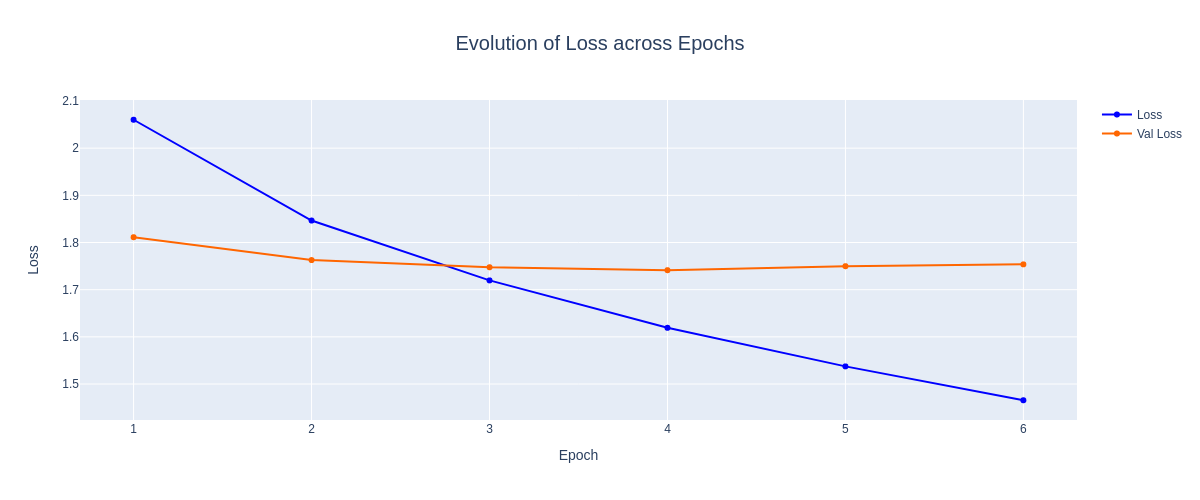

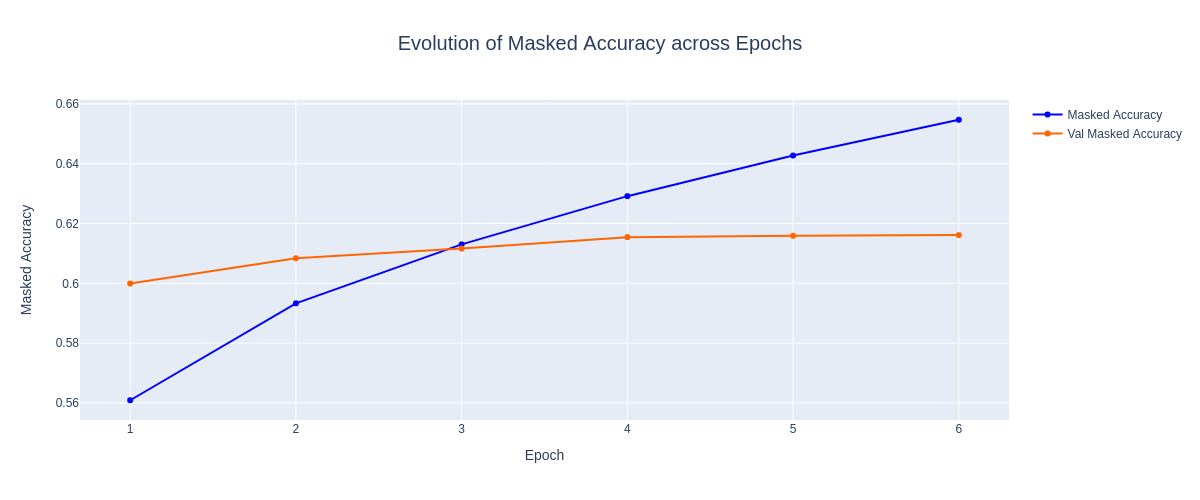

In [ ]:
# Static image for GitHub
plot_metrics(renderer="png")
plot_metrics(metric="masked_accuracy", renderer="png")

### **With the ROUGE Metric**

The [Recall-Oriented Understudy for Gisting Evaluation (ROUGE)](https://huggingface.co/spaces/evaluate-metric/rouge) metric is a set of measures used to evaluate the quality of text translation and summarization. It includes several variants, such as ``rouge1``, which measures the overlap of unigrams between the generated summary and the reference summary; ``rouge2``, which evaluates the overlap of bigrams; ``rougeL``, which considers the longest sequence of overlapping tokens; and  ``rougeLsum``, which computes ROUGE-L at the summary level. Additionally, these metrics can be assessed at different levels of granularity, such as ``low``, ``mid``, and ``high``, representing various thresholds of overlap. Each component of the ROUGE metric is evaluated on a scale from 0 to 1, where 1 indicates an exact match between the predictions and the references.


In [15]:
# Load the trained model
tf.keras.backend.clear_session()
model = TFAutoModelForSeq2SeqLM.from_pretrained(trained_model_path)

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at /content/drive/MyDrive/models/Summarization_T5_XSum.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


**Load the Evaluation Metric**

In [17]:
metric = load_metric("rouge")
metric

Metric(name: "rouge", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Value(dtype='string', id='sequence')}, usage: """
Calculates average rouge scores for a list of hypotheses and references
Args:
    predictions: list of predictions to score. Each prediction
        should be a string with tokens separated by spaces.
    references: list of reference for each prediction. Each
        reference should be a string with tokens separated by spaces.
    rouge_types: A list of rouge types to calculate.
        Valid names:
        `"rouge{n}"` (e.g. `"rouge1"`, `"rouge2"`) where: {n} is the n-gram based scoring,
        `"rougeL"`: Longest common subsequence based scoring.
        `"rougeLSum"`: rougeLsum splits text using `"
"`.
        See details in https://github.com/huggingface/datasets/issues/617
    use_stemmer: Bool indicating whether Porter stemmer should be used to strip word suffixes.
    use_aggregator: Return aggregates if this is set to True
Retu

In [18]:
def prepare_for_evaluation(dataset, batch_size=batch_size):
  list_predictions, list_references = [], []

  for i in tqdm(range(0, len(dataset["document"]), batch_size)):
    batch_data = dataset[i: i+batch_size]

    predictions = model.generate(
        input_ids=tf.constant(batch_data["input_ids"]),
        attention_mask=tf.constant(batch_data["attention_mask"]),
        max_length=max_target_length
    )
    predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # It is necessary to separate sentences with '\n' to accurately calculate the ROUGE metric
    predictions = ["\n".join(nltk.sent_tokenize(prediction)) for prediction in predictions]
    references = ["\n".join(nltk.sent_tokenize(reference)) for reference in batch_data["summary"]]

    list_predictions += predictions
    list_references += references

  return list_predictions, list_references

In [ ]:
predictions, references = prepare_for_evaluation(val_dataset, batch_size=batch_size)

  0%|          | 0/353 [00:00<?, ?it/s]

In [ ]:
result = metric.compute(predictions=predictions, references=references, use_stemmer=True)
result

{'rouge1': AggregateScore(low=Score(precision=0.42241843023188785, recall=0.39016201796467903, fmeasure=0.3986196508705483), mid=Score(precision=0.4252035170430911, recall=0.39284611595322905, fmeasure=0.4011081591281622), high=Score(precision=0.42841808950028804, recall=0.39570243485291434, fmeasure=0.4037896341150795)),
 'rouge2': AggregateScore(low=Score(precision=0.17779349290934135, recall=0.1642887893318034, fmeasure=0.1676728819913868), mid=Score(precision=0.18050433869451335, recall=0.16692064787263358, fmeasure=0.17030496284038604), high=Score(precision=0.1830641871040768, recall=0.16953983889241983, fmeasure=0.1727869168814103)),
 'rougeL': AggregateScore(low=Score(precision=0.33818254359369915, recall=0.3129862576629289, fmeasure=0.3193264584082806), mid=Score(precision=0.34111538613928694, recall=0.3157030008338104, fmeasure=0.3220763769912538), high=Score(precision=0.3440645093151206, recall=0.3185567917584112, fmeasure=0.3248030721221415)),
 'rougeLsum': AggregateScore(lo

In [ ]:
result = {key: value.mid.fmeasure*100 for key, value in result.items()}
result

{'rouge1': 40.11081591281622,
 'rouge2': 17.030496284038605,
 'rougeL': 32.20763769912538,
 'rougeLsum': 32.198009012217774}

 The results obtained on the validation dataset are as follows: **`rouge1`: 40.11**, **`rouge2`: 17.03**, **`rougeL`: 32.21**, **`rougeLsum`: 32.2**. These values indicate that the model has medium to high quality. As will be shown later, the model generally performs well in summarizing both short and long texts, but even so, `rouge1` does not exceed 50%. This is because abstractive summarization is a challenging task, more so than translation, and there is only one very concise reference (real summary) for each prediction. Of course, as with translation, ROUGE scores would be higher with multiple references since summaries can vary in length and use synonymous words.

Moreover, it is important to note that even more advanced models, such as **BART Large** (over 400 million parameters) fine-tuned with this same XSum dataset, achieve only a [**`rouge1` score of 45.45**](https://huggingface.co/facebook/bart-large-xsum) (not exceeding 50%) on the test dataset, highlighting the complexity of the text summarization task.

Finally, it is worth mentioning that, as stated in the [T5 research paper](https://jmlr.org/papers/volume21/20-074/20-074.pdf), a higher ROUGE score does not always mean higher quality summaries. However, compared to the Transformer model trained from scratch (`rouge1` of 27.66), significantly better results are achieved both in the ROUGE metric and in summary quality.

## **Generating Summaries with the Trained Model**

In [31]:
# Function to generate summaries and display them in HTML format

def display_summary(text, reference=None):
  text = preprocessing(text)
  inputs = tokenizer(
      [prefix + text],
      truncation=True,
      max_length=max_context_length,
      return_tensors="tf"
  )

  prediction = model.generate(**inputs, max_length=max_target_length)[0]
  prediction = tokenizer.decode(prediction, skip_special_tokens=True)

  #Replace `\n` with `<br>` to make the line break visible in HTML format
  text = text.replace("\n", "<br>")
  content_html = f"""
  <b>Text:<br></b> {text}<br><br>
  <b>Summary:</b> {prediction}<br><br>
  """

  if reference is not None:
    reference = preprocessing(reference)

    result = metric.compute(
        predictions=["\n".join(nltk.sent_tokenize(prediction))],
        references=["\n".join(nltk.sent_tokenize(reference))],
        use_stemmer=True
    )
    result = {key: value.mid.fmeasure*100 for key, value in result.items()}

    content_html += f"<b>Reference:</b> {reference}<br><br>"
    for key, value in result.items():
      content_html += f"<b><span style='color: blue'>{key}:</span></b> {round(value, 2)}&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"

  display(HTML(content_html))

### **Validation Dataset**

In [ ]:
len_data = len(val_dataset)

In [39]:
id = np.random.randint(len_data)
sample = val_dataset[id]

display_summary(sample["document"], sample["summary"])

In [ ]:
id = np.random.randint(len_data)
sample = val_dataset[id]

display_summary(sample["document"], sample["summary"])

In [ ]:
id = np.random.randint(len_data)
sample = val_dataset[id]

display_summary(sample["document"], sample["summary"])

In [ ]:
id = np.random.randint(len_data)
sample = val_dataset[id]

display_summary(sample["document"], sample["summary"])

**Long Texts**

In [ ]:
id = np.random.randint(len_data)
sample = val_dataset[id]

display_summary(sample["document"], sample["summary"])

In [ ]:
id = np.random.randint(len_data)
sample = val_dataset[id]

display_summary(sample["document"], sample["summary"])

In [ ]:
id = np.random.randint(len_data)
sample = val_dataset[id]

display_summary(sample["document"], sample["summary"])

In [ ]:
id = np.random.randint(len_data)
sample = val_dataset[id]

display_summary(sample["document"], sample["summary"])

### **Other Texts**

In [ ]:
text = """
Facebook has announced a new feature that allows users to create custom avatars for use in comments and messages.
The avatars can be personalized to look like the users themselves, with options for different hairstyles, outfits,
and accessories. This move is seen as a direct response to similar features offered by Snapchat and Apple.
"""

display_summary(text)

In [ ]:
text = """
The global economy is facing significant challenges due to the ongoing trade war between the United States and China.
Tariffs imposed by both countries have disrupted supply chains, increased costs for businesses, and led to higher prices
for consumers. Economists warn that if the conflict continues, it could lead to a global recession. The International Monetary
Fund has already revised its growth forecast for the year, citing the trade war as a major factor. Both countries have held
several rounds of negotiations, but a resolution remains elusive.
"""

display_summary(text)

In [ ]:
text = """
A massive industrial accident at a chemical plant in Texas has resulted in multiple fatalities and injuries.
The explosion occurred in the early hours of the morning, sending shockwaves through the nearby community.
Firefighters and emergency response teams rushed to the scene, battling the blaze and rescuing trapped workers.
Authorities have confirmed that ten people were killed and dozens more injured, some critically. The cause of the
explosion is still under investigation, but initial reports suggest that a gas leak might have ignited the blast.
The incident has raised serious concerns about safety regulations and emergency preparedness at industrial facilities.
Local officials have called for a thorough review of safety protocols to prevent such catastrophic events in the future.
"""

display_summary(text)

In [ ]:
text = """
Major technology companies are making significant investments in renewable energy to power their operations sustainably.
Companies like Google, Apple, and Microsoft have committed to running their data centers and offices entirely on renewable
energy sources such as wind, solar, and hydroelectric power.

Google has signed numerous power purchase agreements (PPAs) with wind and solar farms, aiming to match 100% of its energy
use with renewable energy purchases. Apple has achieved its goal of using 100% renewable energy for its global facilities
and is now focusing on helping its suppliers make the same transition. Microsoft has launched an ambitious plan to become
carbon negative by 2030, removing more carbon from the environment than it emits. The company is investing in innovative
technologies like carbon capture and storage, and supporting reforestation projects.

These efforts not only help combat climate change but also set an example for other industries to follow. By leveraging their
substantial financial resources and technological expertise, tech giants are driving significant progress in the renewable energy sector.
"""

display_summary(text)

**Long Texts**

**[The New York Times: Bomb Smuggled Into Iran Guesthouse Months Ago Killed Hamas Leader](https://www.nytimes.com/2024/08/01/world/middleeast/how-hamas-leader-haniyeh-killed-iran-bomb.html)**

In [ ]:
text = """
Ismail Haniyeh, a top leader of Hamas, was assassinated on
Wednesday by an explosive device covertly smuggled into the
Tehran guesthouse where he was staying, according to seven
Middle Eastern officials, including two Iranians, and an American
official.

The bomb had been hidden approximately two months ago in the
guesthouse, according to five of the Middle Eastern officials. The
guesthouse is run and protected by the Islamic Revolutionary
Guards Corps and is part of a large compound, known as Neshat, in
an upscale neighborhood of northern Tehran.

Mr. Haniyeh was in Iran's capital for the presidential inauguration.
The bomb was detonated remotely, the five officials said, once it
was confirmed that he was inside his room at the guesthouse. The
blast also killed a bodyguard.

The explosion shook the building, shattered some windows and
caused the partial collapse of an exterior wall, according to the two
Iranian officials, members of the Revolutionary Guards briefed on
the incident. Such damage was also evident in a photograph of the
building shared with The New York Times.

Mr. Haniyeh, who had led Hamas's political office in Qatar, had
stayed at the guesthouse several times when visiting Tehran,
according to the Middle Eastern officials. All of the officials spoke
on the condition of anonymity to share sensitive details about the
assassination.
"""

display_summary(text)

**[BBC: Three men accused of plotting 9/11 reach plea deal - Pentagon](https://www.bbc.com/news/articles/cldy01z6xnpo)**

In [ ]:
text = """
Three of the men accused of plotting the 11 September, 2001 terrorist attacks have
entered into a pre-trial agreement, the US Department of Defence says.

Khalid Sheikh Mohammad, Walid Muhammad Salih Mubarak Bin Attash, and
Mustafa Ahmed Adam al-Hawsawi have been held at the US Navy base Guantanamo
Bay, Cuba, for years without going to trial.

According to US news outlets, the men will plead guilty in exchange for the
prosecution agreeing not to seek the death penalty.

The terms of the plea deal have not yet been released.

Nearly 3,000 people in New York, Virginia and Pennsylvania were killed in the al-
Qaeda attacks, which sparked the "War on Terror" and the invasions of Afghanistan
and Iraq.

They were the deadliest assault on US soil since the 1941 Japanese attack on Pearl
Harbour, Hawaii, where 2,400 people were killed.

The deal was first announced in a letter sent by prosecutors to the family of victims,
according to The New York Times.

"In exchange for the removal of the death penalty as a possible punishment, these
three accused have agreed to plead guilty to all of the charged offenses, including the
murder of the 2,976 people listed in the charge sheet," said the letter from chief
prosecutor Rear Admiral Aaron Rugh.

The men have been accused of a litany of charges, including attacking civilians,
murder in violation of the laws of war, hijacking and terrorism.

They are expected to formally submit their pleas in court as early as next week, the
Times reported.
"""

display_summary(text)

**[BBC: CrowdStrike sued by shareholders over global outage](https://www.bbc.com/news/articles/cy08ljxndr4o)**

In [ ]:
text = """
CrowdStrike is being sued by its shareholders after a faulty software update by the
cybersecurity firm crashed more than eight million computers and caused chaos
around the world.

The lawsuit accuses the company of making "false and misleading" statements about
its software testing.

It also says the company's share price dropped 32% in the 12 days after the incident,
causing a loss in market value of $25bn (£14.5bn).

CrowdStrike denies the allegations and says it will defend itself against the proposed
class action lawsuit.

Meanwhile, the firm has said computers affected by the massive global IT outage are
effectively now back to normal.

The US-based company stated that as of 5pm local time on Monday, 29 July (00:00,
Tuesday GMT), the outage had been fixed - ten days after the incident began.

The suit filed in the Austin, Texas federal court, alleges that CrowdStrike executives
defrauded investors by making them believe the company's software updates were
adequately tested.

The lawsuit is seeking an unspecified amount of compensation for investors who
owned CrowdStrike shares between 29 November and 29 July.

It cites chief executive George Kurtz, who said in a conference call on 5 March that the
firm's software was "validated, tested and certified."

CrowdStrike told BBC News that its disputes the claims.

"We believe this case lacks merit and we will vigorously defend the company," a
spokesperson said.
"""

display_summary(text)

**Conclusion:** The model is effective in generating summaries of both short and long texts. However, if further improvement is desired, it is necessary to fine-tune or use larger and more robust models, such as T5 Large or BART Large. Additionally, to enable the model to generate summaries that are not only concise but also longer and more detailed, it is necessary to fine-tune it with more robust datasets, which will require better computational capabilities than the free TPU of Colab (or many more hours of training using TensorFlow checkpoints). Nonetheless, for generating concise summaries of news articles, this model is more than sufficient.